<a href="https://colab.research.google.com/github/Mostafa-MMK/VaRBacktestingEngine/blob/main/0_historical_var_es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Packages

In [ ]:
# Installing Packages
!pip install yfinance scienceplots --quiet
!apt-get update -qq
!apt-get install -y texlive-latex-extra texlive-fonts-recommended dvipng cm-super --quiet


# For latex text in the graphs
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})



# Main Functions (OOP)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import yfinance as yf

# Creating an OOP functions for VaR and ES Estimator under Historical Simulation
class VaR_ES_Framework:
  def __init__(self, tickers):
    self.tickers = tickers
    self.df_returns = None # for future use

  def data_preparation(self):
    # Download data and wrangle to calc returns
    df = yf.download(self.tickers, start = '2020-01-01', auto_adjust = False)['Close'].dropna()
    df.columns = self.tickers
    df_returns = np.log(df / df.shift(1)).dropna()
    self.df_returns = df_returns
    return df_returns

  def Hist_VaR_ES_Calculator(self):
    # Check about the returns, if not found --> trigger this
    if self.df_returns is None:
      df_returns = self.data_preparation()
    df_returns = self.df_returns

    # Sorting returns
    sorted_return = df_returns.apply(np.sort)
    confidence_levels = np.arange(0.90, 1.0, 0.01)
    results = []

    # Calculating VaR and ES for each assets with different confidence levels
    for conf in confidence_levels:
      for tick in self.tickers:
        vars_ = np.quantile(sorted_return[tick], (1 - conf))
        es_ = sorted_return[tick][sorted_return[tick] <= vars_].mean()
        results.append({'Confidence': conf, 'Ticker': tick, 'VaR': vars_, 'ES': es_})

    # Creating dataframe of the results
    df_results = pd.DataFrame(results)
    df_results.set_index('Confidence', inplace = True)
    return df_results

    # Monte-Carlo Simulated VaR and ES
  def Monte_Carlo_VaR_ES(self):
    rng = np.random.default_rng(10)
    num_simulation = 10000
    confidences = np.arange(0.90, 1.0, 0.01)
    mu = self.df_returns.mean()
    sigma = self.df_returns.std()

    sample_returns = rng.normal(loc = mu, scale = sigma, size = (num_simulation, len(self.df_returns.columns)))
    sorted_returns = (pd.DataFrame(sample_returns, columns = self.df_returns.columns)).apply(np.sort)
    mc_results = []

    for conf in confidences:
      for tick in self.tickers:
        vars_ = np.quantile(sorted_returns[tick], (1 - conf))
        es_ = sorted_returns[tick][sorted_returns[tick] <= vars_].mean()
        mc_results.append({'Confidence': conf, 'Ticker': tick, 'VaR': vars_, 'ES': es_})
    mc_results = pd.DataFrame(mc_results)
    mc_results.set_index('Confidence', inplace = True)
    return mc_results


# Executions

In [6]:
# Results
tickers = ['AAPL', 'TSLA', 'GOOG', 'MSFT']
framework = VaR_ES_Framework(tickers)
df_returns = framework.data_preparation()
df_results = framework.Hist_VaR_ES_Calculator()
mc_results = framework.Monte_Carlo_VaR_ES()

[*********************100%***********************]  4 of 4 completed


# Plotting Results

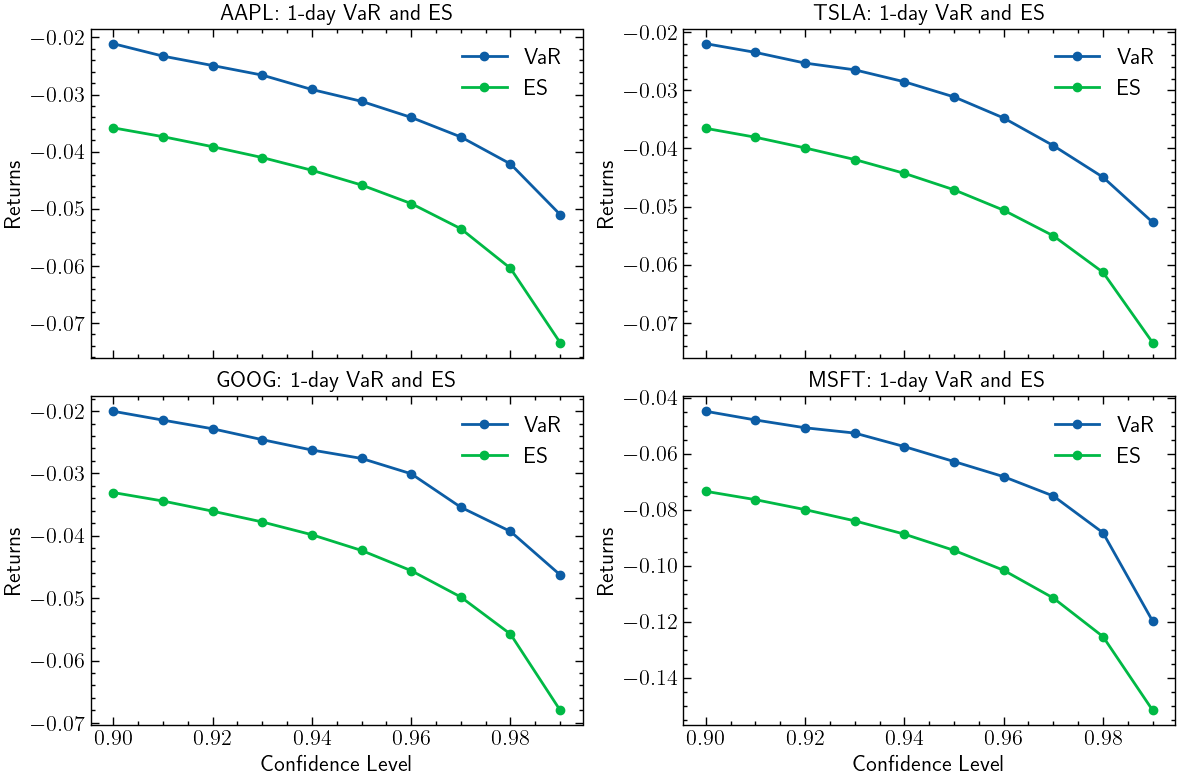

In [5]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  df_results[df_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)

plt.tight_layout()
plt.show()

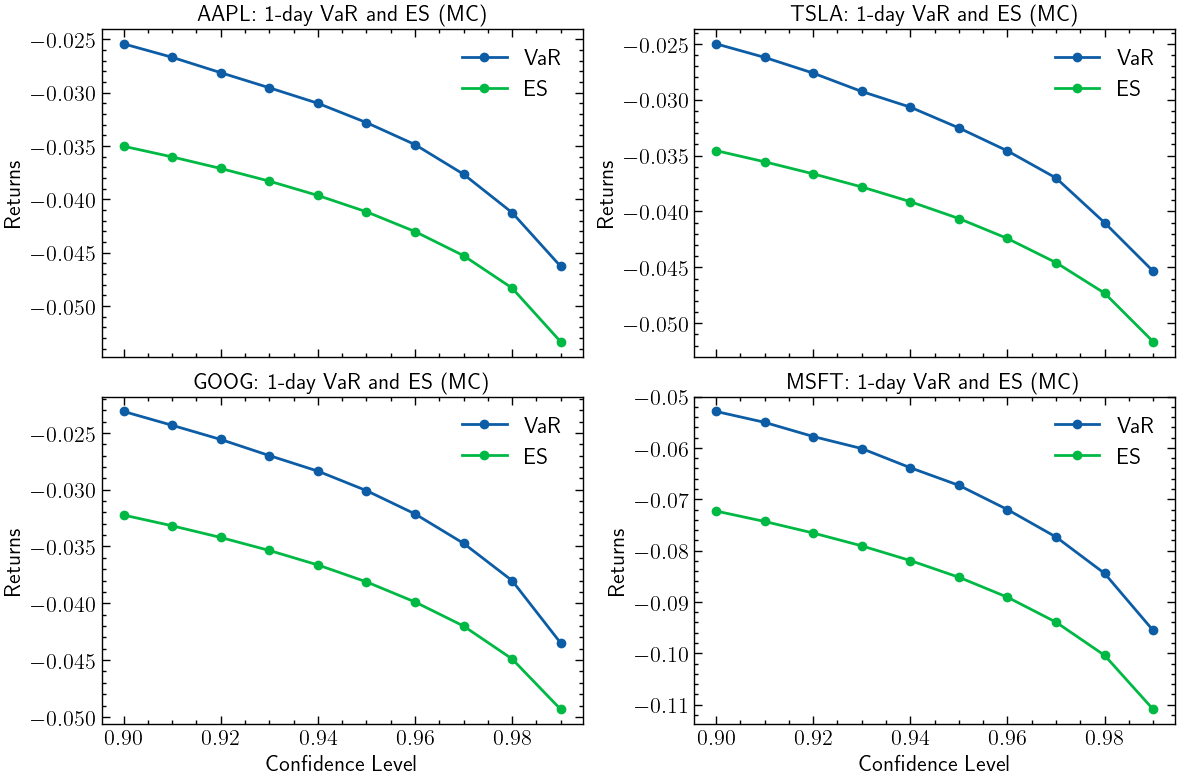

In [8]:
# Creating plots for each asset

plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8), sharex = True, sharey = False)
axes = axes.flatten()

for tick, ax in zip(tickers, axes):
  mc_results[mc_results.Ticker == tick].plot(ax = ax, marker = 'o')
  ax.set_title(f"{tick}: 1-day VaR and ES (MC)" )
  ax.set_xlabel('Confidence Level')
  ax.set_ylabel('Returns')
  ax.legend(loc = 'best', frameon = False)
  ax.grid(False)
plt.tight_layout()
plt.show()